In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
import plotly.express as px 

import sys 
sys.path.append('../')

from src.datasets.data import PAMAP2Reader

In [2]:
dataReader = PAMAP2Reader('../data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\notebooks\..\src\datasets\data.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [18]:
dataReader.data[0].shape

(8120, 27)

In [21]:
sample_data = dataReader.data[0][:200, :]

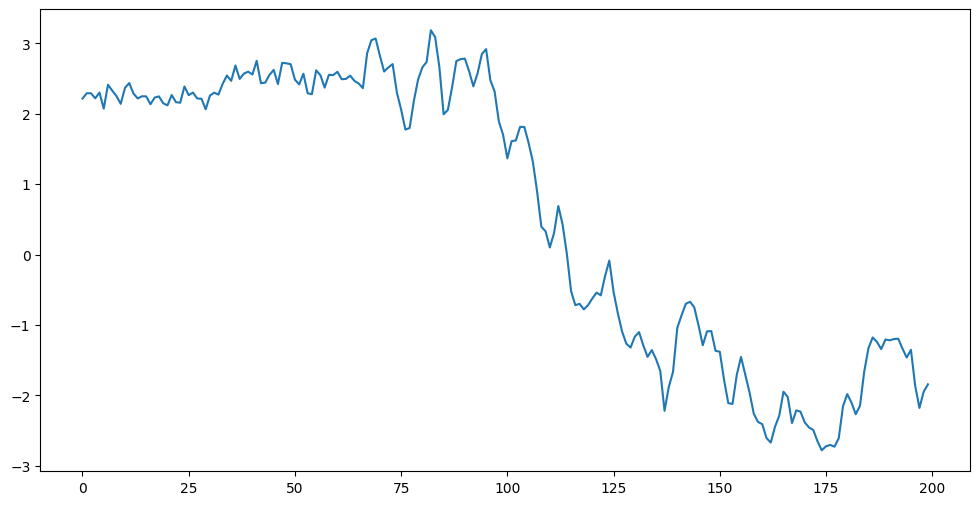

In [26]:
plt.figure(figsize=(12,6))

s0 = sample_data[:, 0]
plt.plot(s0)

In [7]:
import numpy
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise Exception('smooth only accepts 1 dimension arrays.')
        if x.size < window_len:
                raise Exception("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise Exception("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

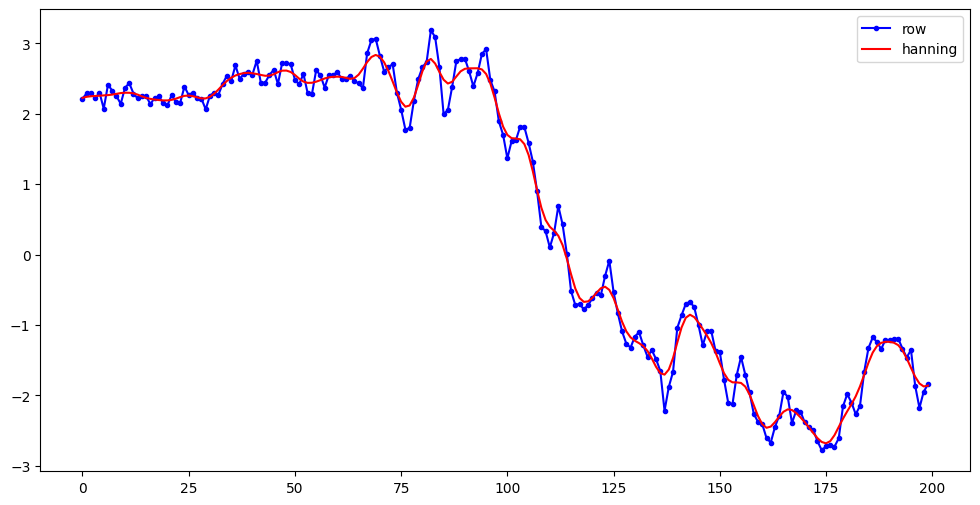

In [67]:
smoothed_sig = smooth(s0)

plt.figure(figsize=(12,6))
plt.plot(s0, color='blue', marker='.', label='row')
plt.plot(smoothed_sig, color='red', label='hanning')
plt.legend(('row', 'hanning'), loc='upper right')

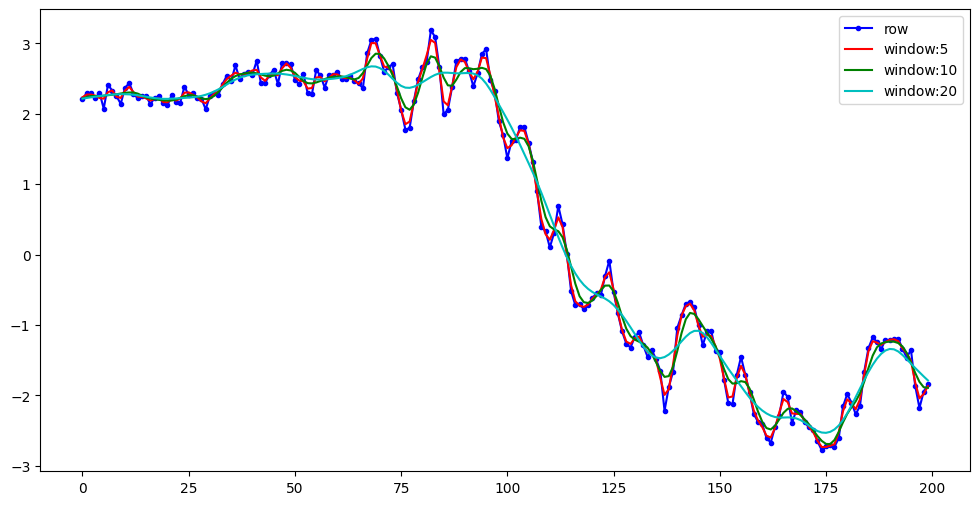

In [40]:
w5_sig = smooth(s0, window_len=5)
w10_sig = smooth(s0, window_len=10)
w20_sig = smooth(s0, window_len=20)

plt.figure(figsize=(12,6))
plt.plot(s0, color='blue', marker='.', label='row')
plt.plot(w5_sig, color='red', label='window:5')
plt.plot(w10_sig, color='green', label='window:10')
plt.plot(w20_sig, color='c', label='window:20')
plt.legend(('row', 'window:5', 'window:10', 'window:20'), loc='upper right')

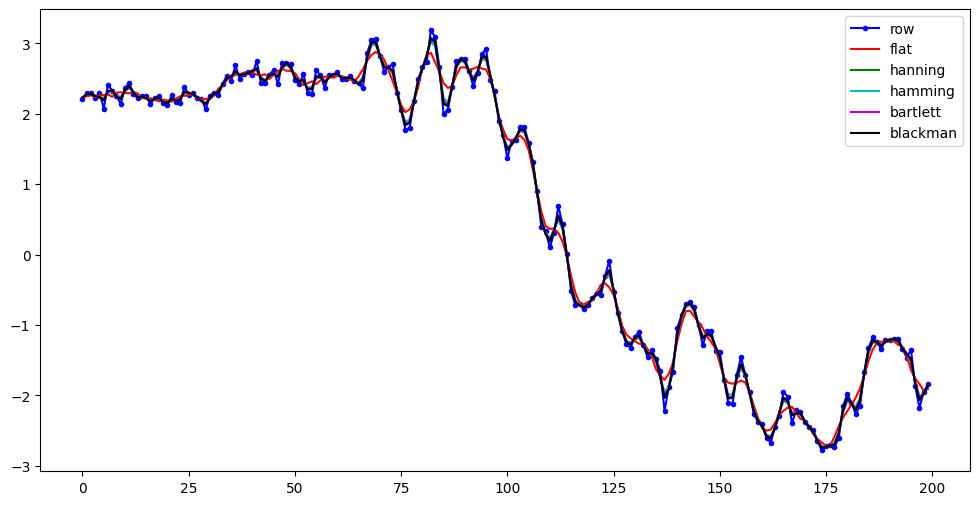

In [42]:

flat_sig = smooth(s0, window='flat', window_len=5)
han_sig = smooth(s0, window='hanning', window_len=5)
ham_sig = smooth(s0, window='hamming', window_len=5)
bar_sig = smooth(s0, window='bartlett', window_len=5)
black_sig = smooth(s0, window='blackman', window_len=5)

plt.figure(figsize=(12,6))
plt.plot(s0, color='blue', marker='.', label='row')
plt.plot(flat_sig, color='red', label='flat')
plt.plot(han_sig, color='green', label='hanning')
plt.plot(ham_sig, color='c', label='hamming')
plt.plot(bar_sig, color='m', label='bartlett')
plt.plot(black_sig, color='k', label='blackman')
plt.legend(('row', 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'), loc='upper right')

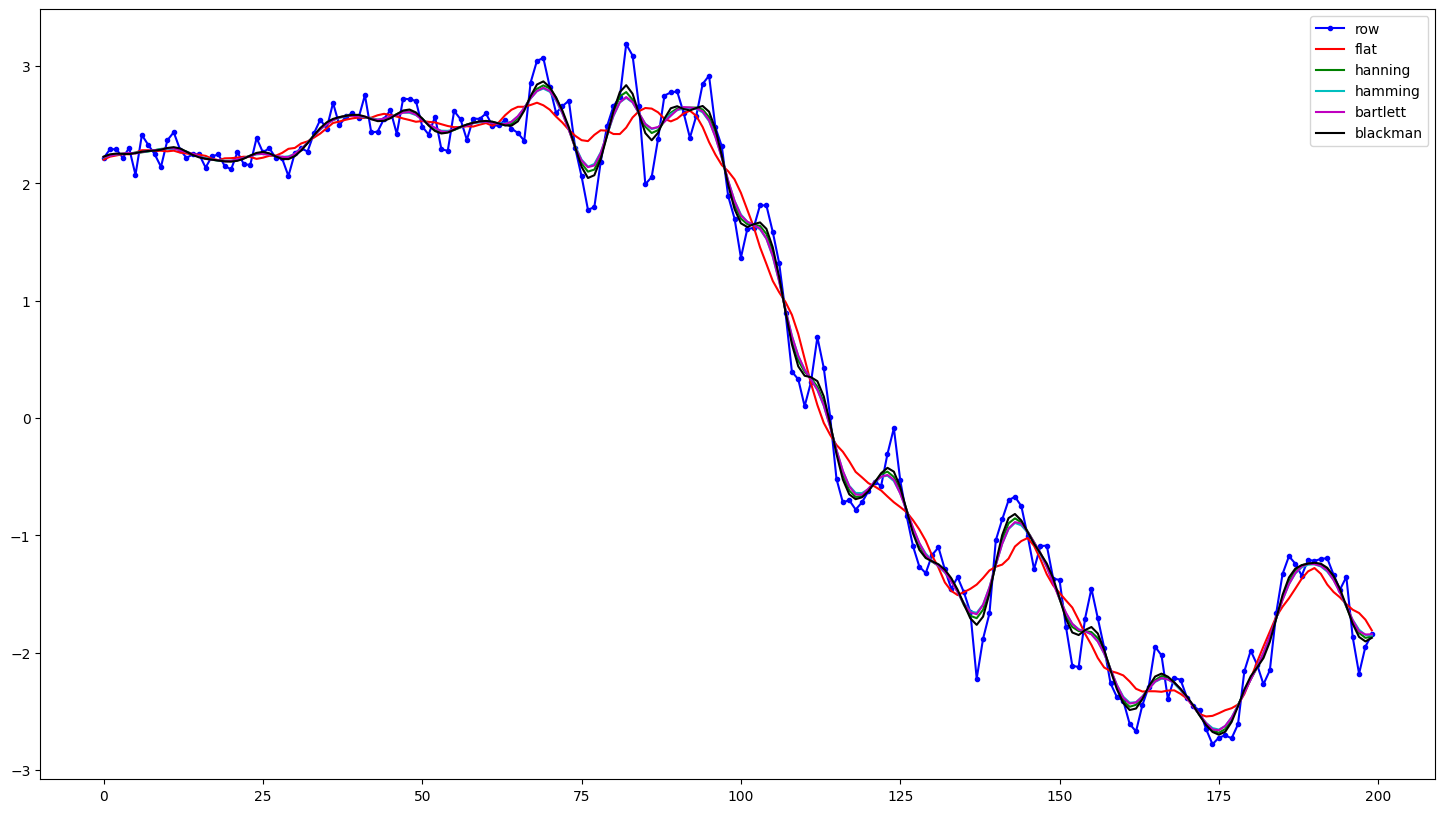

In [44]:

flat_sig = smooth(s0, window='flat')
han_sig = smooth(s0, window='hanning')
ham_sig = smooth(s0, window='hamming')
bar_sig = smooth(s0, window='bartlett')
black_sig = smooth(s0, window='blackman')

plt.figure(figsize=(18,10))
plt.plot(s0, color='blue', marker='.', label='row')
plt.plot(flat_sig, color='red', label='flat')
plt.plot(han_sig, color='green', label='hanning')
plt.plot(ham_sig, color='c', label='hamming')
plt.plot(bar_sig, color='m', label='bartlett')
plt.plot(black_sig, color='k', label='blackman')
plt.legend(('row', 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'), loc='upper right')

In [3]:
data_dict = dataReader.generate(unseen_classes=[1,3], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20, smoothing=False)

In [4]:
data_dict['train']['X'].shape

(17919, 105, 27)

In [5]:
sample_data1 = data_dict['train']['X'][0]
d0 = sample_data1[:, 0]

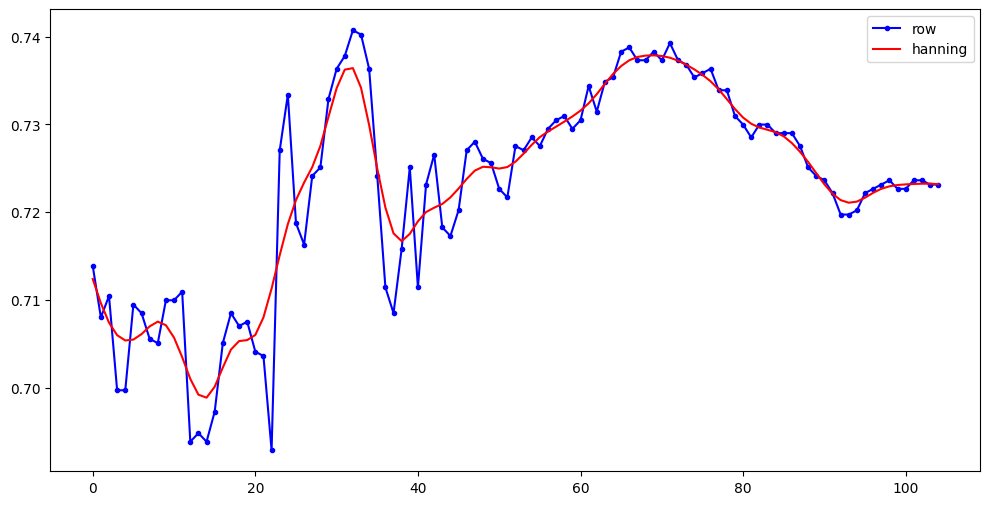

In [8]:
smoothed_sig = smooth(d0)

plt.figure(figsize=(12,6))
plt.plot(d0, color='blue', marker='.', label='row')
plt.plot(smoothed_sig, color='red', label='hanning')
plt.legend(('row', 'hanning'), loc='upper right')

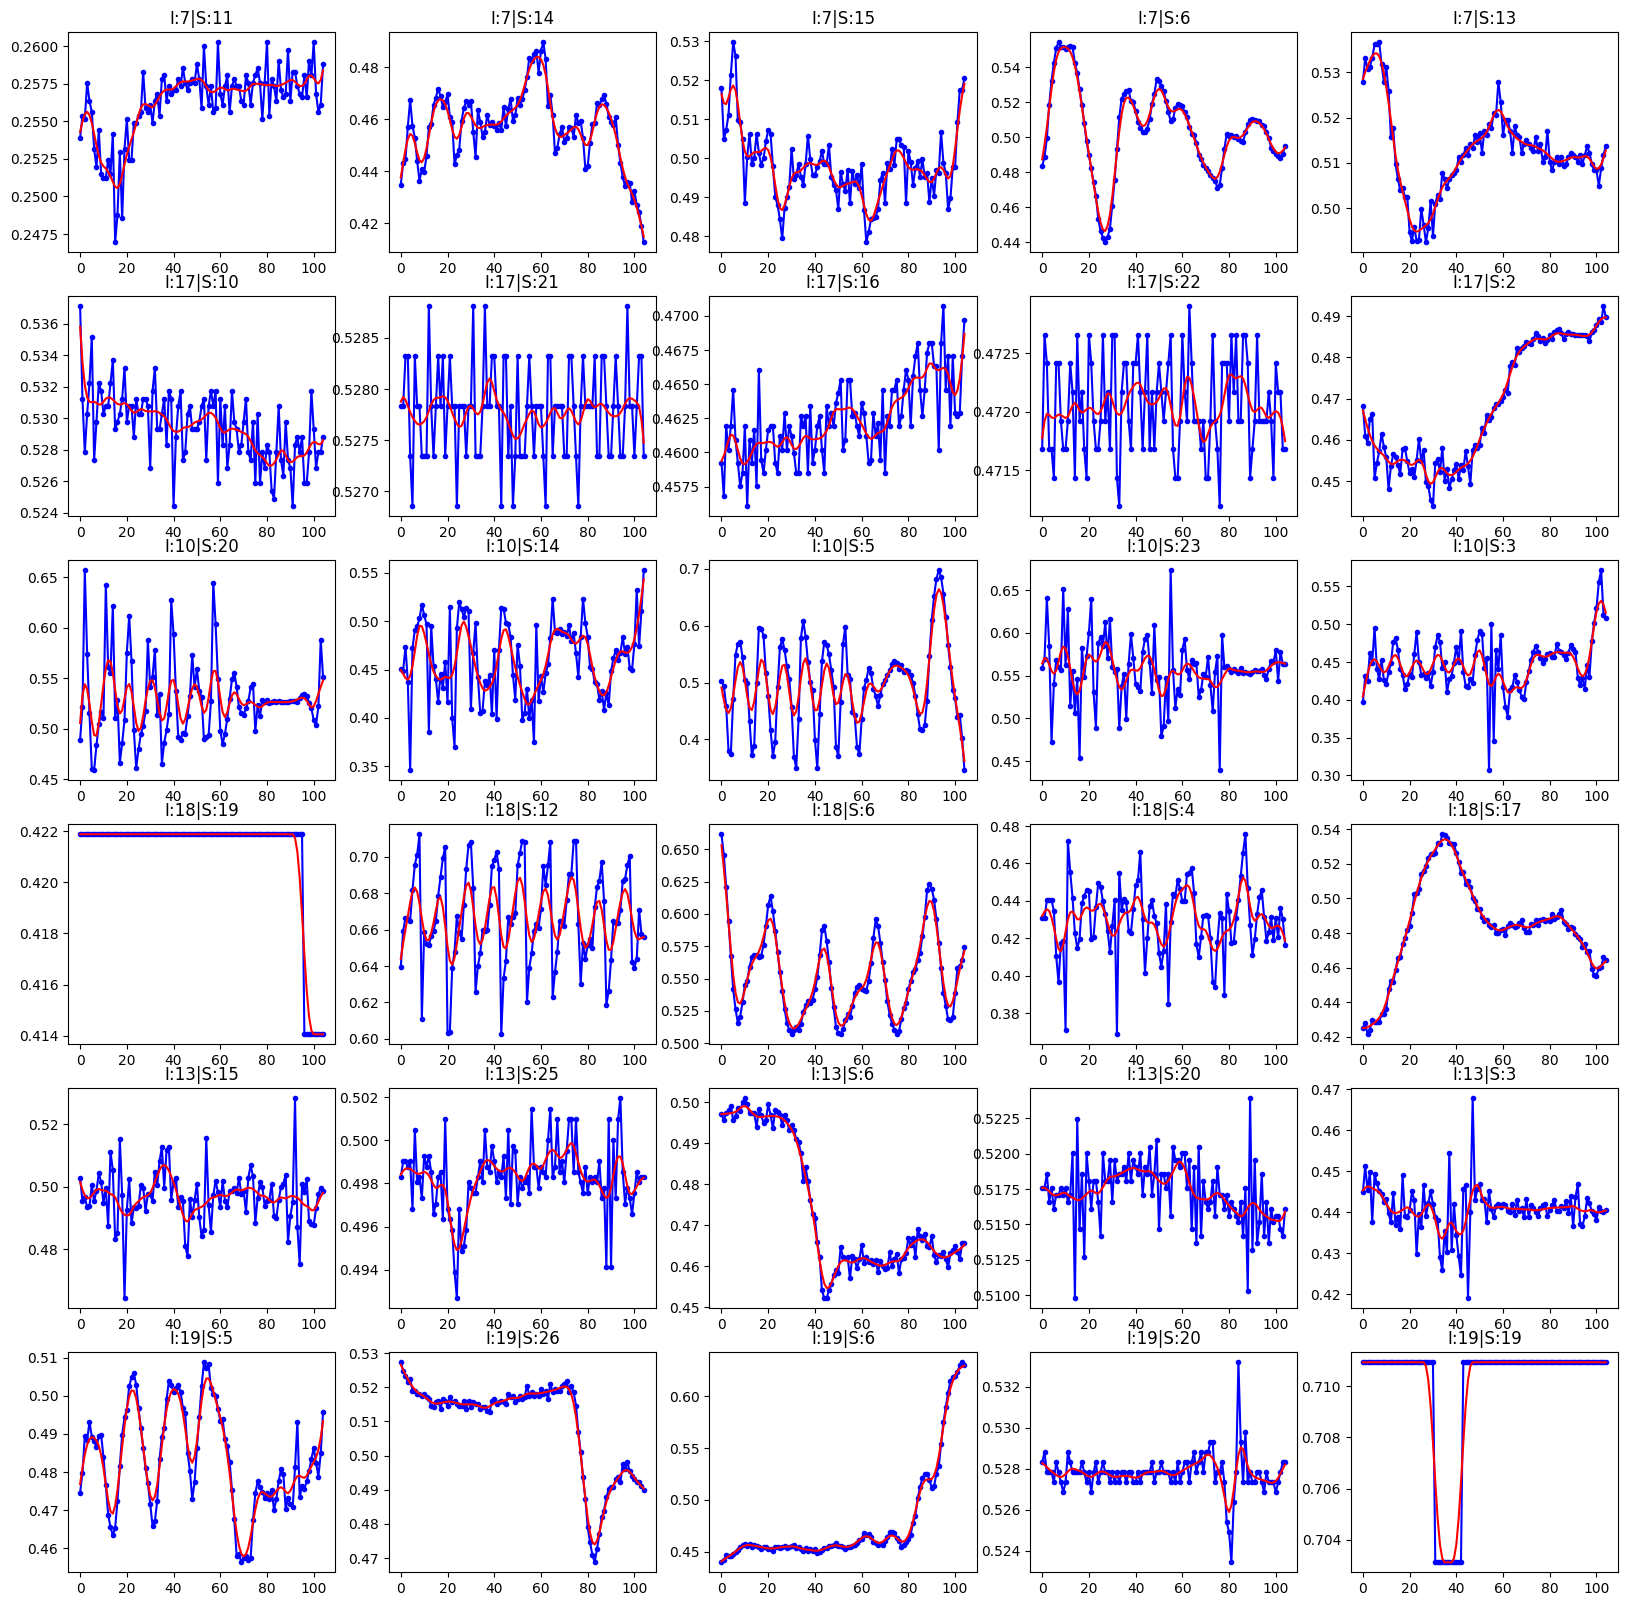

In [9]:
from random import sample, choice
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))

for i, r in enumerate(sample(range(20), k=6, )):
    for j, c in enumerate(sample(range(27), k=5)):
        s = data_dict['train']['X'][r, :, c]
        ss = smooth(s)
        axs[i, j].plot(s, color='blue', marker='.', label='row')
        axs[i, j].plot(ss, color='red', label='hanning')
        axs[i, j].set_title(f"I:{r}|S:{c}")

In [10]:
sms_data1 = np.apply_along_axis(smooth, axis=1, arr=data_dict['train']['X'])[0]

In [62]:
sms_data1.shape

(105, 27)

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))

for i in range(6):
    for j in range(5):
        s = sms_data1[:, i*6+j]
        # ss = smooth(s)
        axs[i, j].plot(s, color='blue', marker='.', label='row')
        axs[i, j].plot(sample_data1[:, i*6+j], color='red', label='hanning')
        axs[i, j].set_title(f"I:{r}|S:{c}")

IndexError: index 27 is out of bounds for axis 1 with size 27

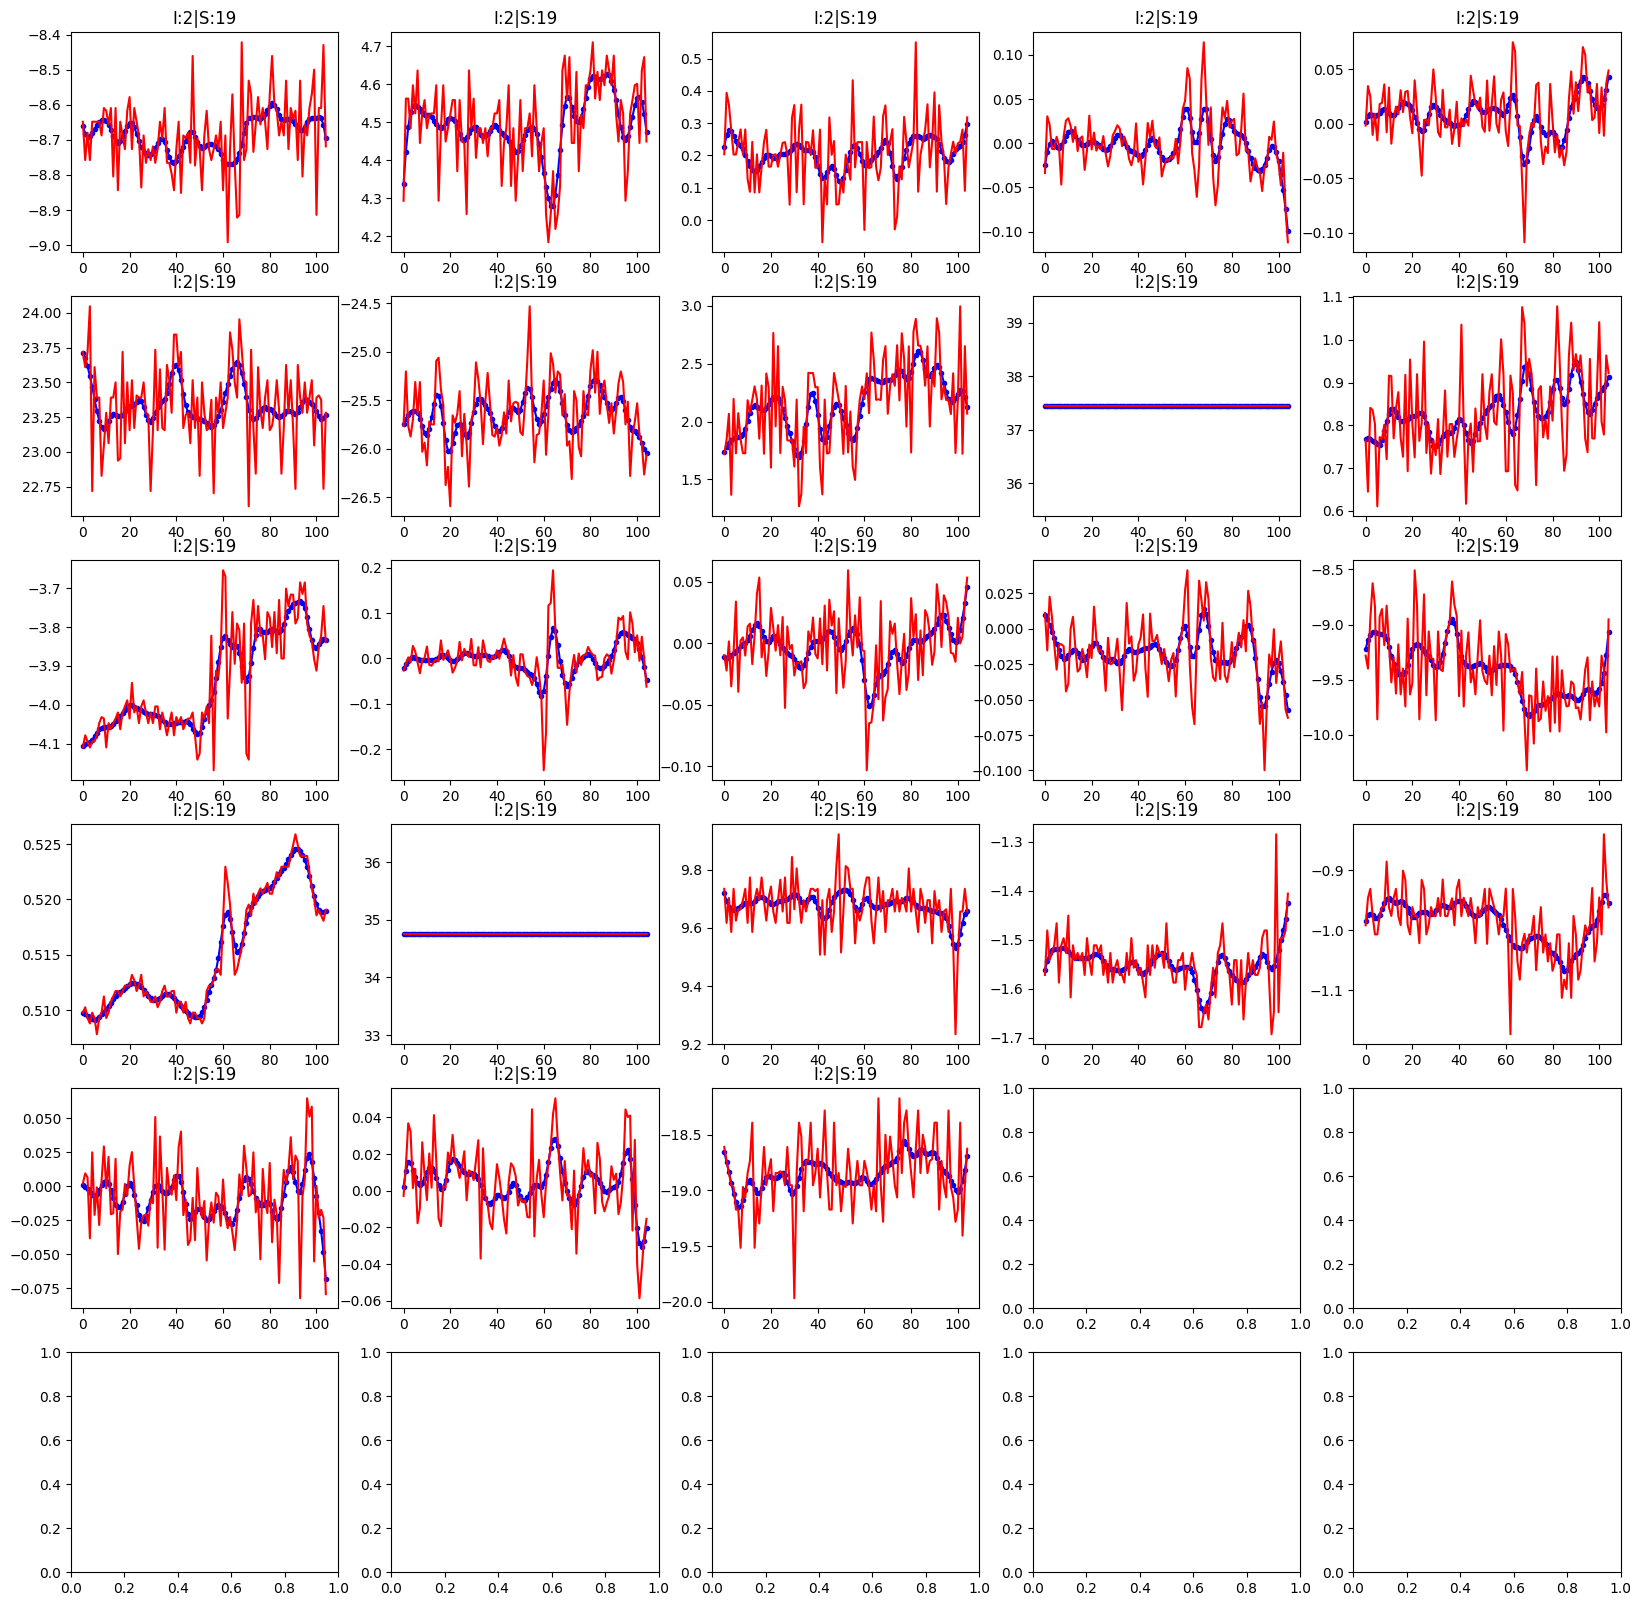

In [65]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))

for i in range(6):
    for j in range(5):
        s = sms_data1[:, i*6+j]
        # ss = smooth(s)
        axs[i, j].plot(s, color='blue', marker='.', label='row')
        axs[i, j].plot(sample_data1[:, i*6+j], color='red', label='hanning')
        axs[i, j].set_title(f"I:{r}|S:{c}")

IndexError: index 27 is out of bounds for axis 1 with size 27

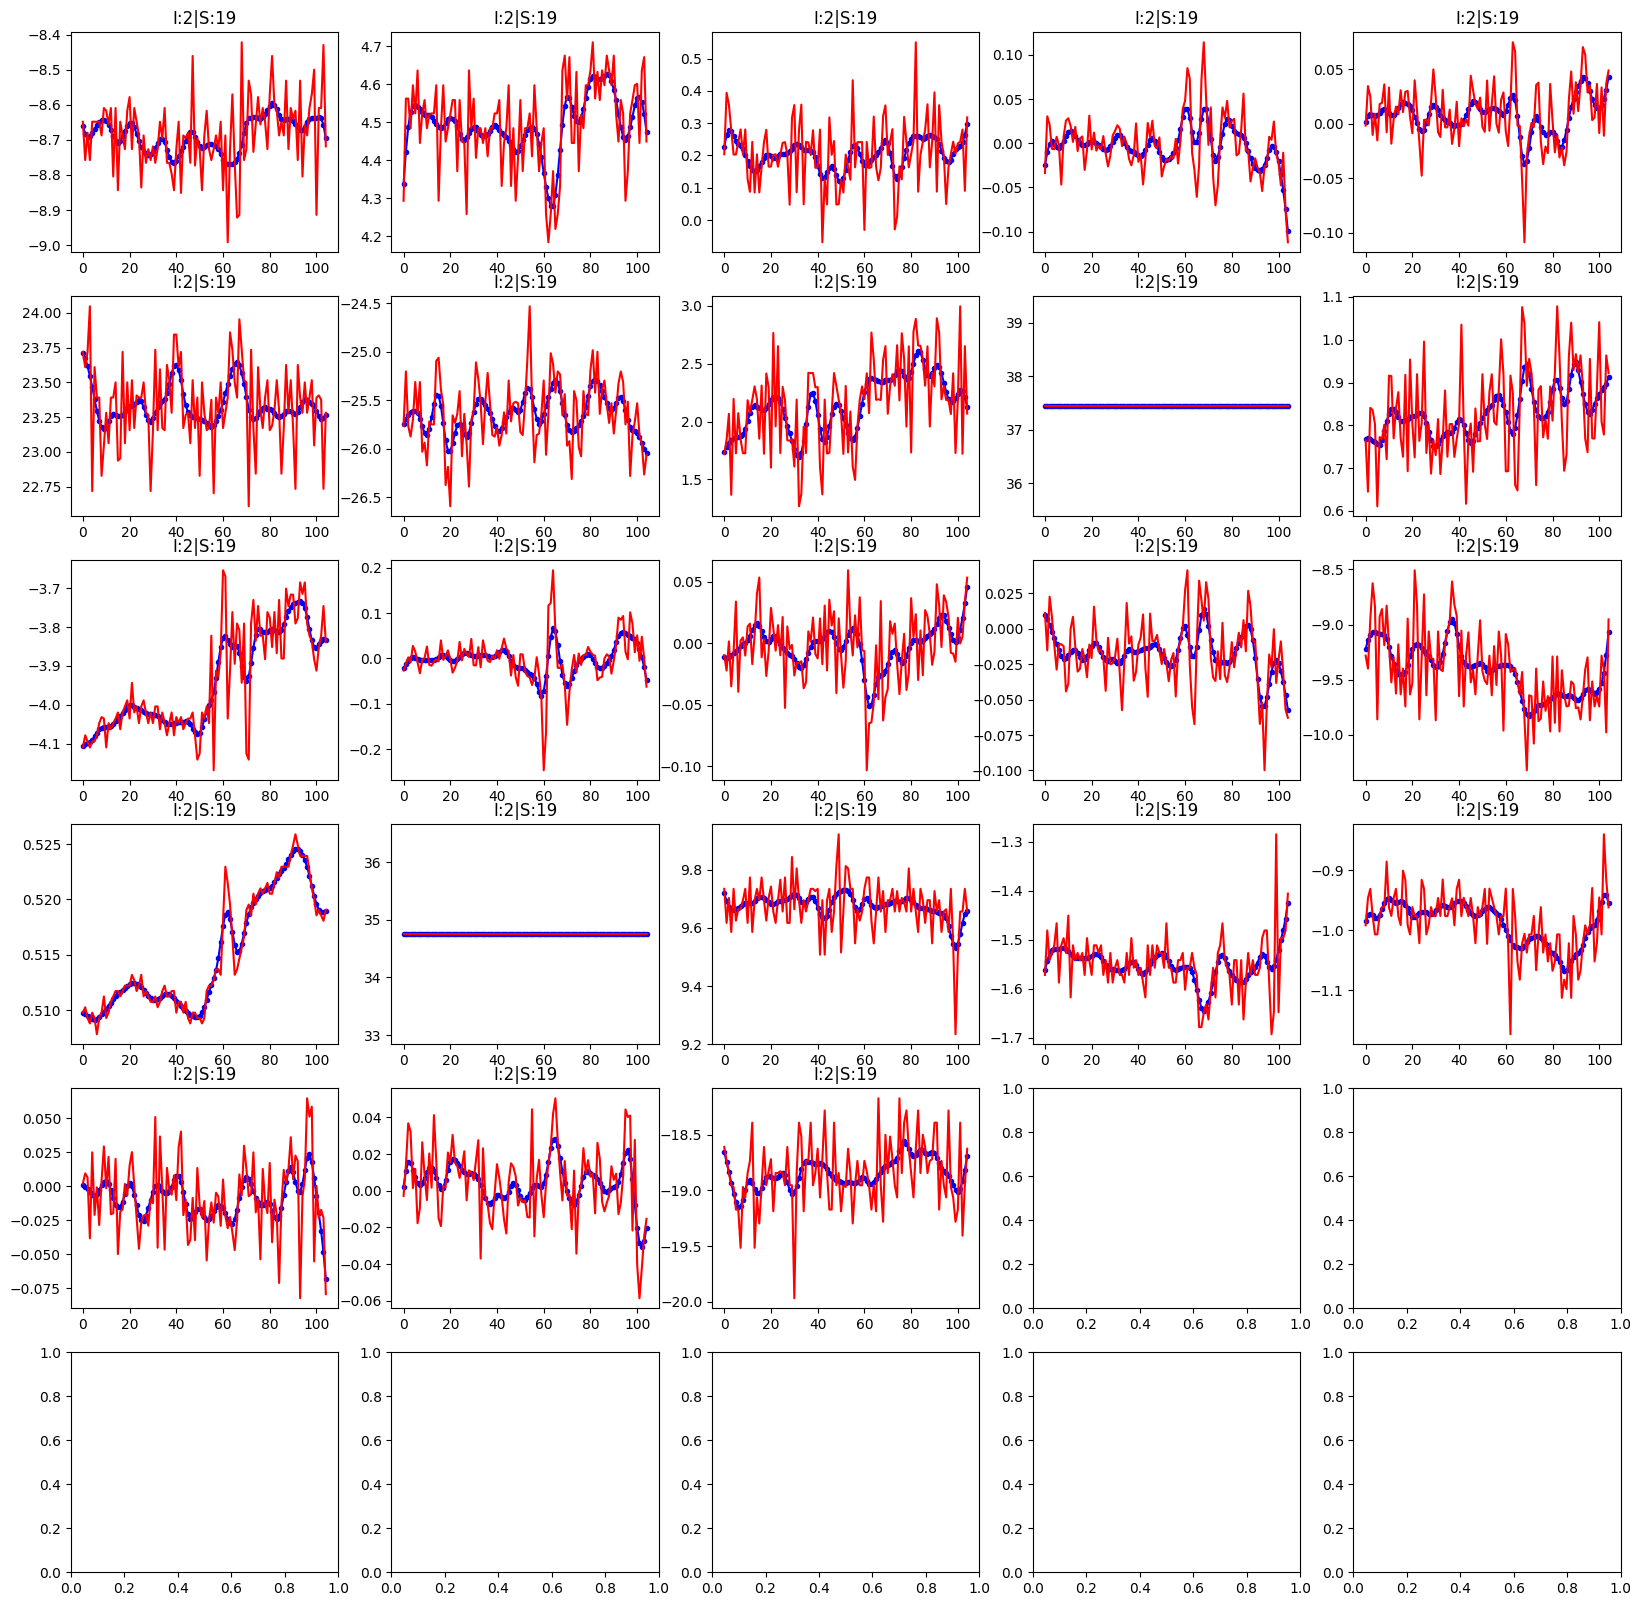

In [63]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))

for i in range(6):
    for j in range(5):
        s = sms_data1[:, i*6+j]
        # ss = smooth(s)
        axs[i, j].plot(s, color='blue', marker='.', label='row')
        axs[i, j].plot(sample_data1[:, i*6+j], color='red', label='hanning')
        axs[i, j].set_title(f"I:{r}|S:{c}")